<a href="https://colab.research.google.com/github/HuyenNguyenHelen/INFO-5505---Machine-learning/blob/main/HuyenNguyen_Assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 6: Image Classification with Convolutional Neural Network
Dataset: [Intel Image Classification dataset](https://www.kaggle.com/puneet6060/intel-image-classification/data#)

Goal: Classify images into 6 categories: building, forest, glacier, mountain, sea, and street.

In [20]:
# Import essential libraries
import tensorflow as tf
import timeit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob as gb 
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns



In [21]:
# Checking the GPU installed
# %tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Loading data from Kaggle

In [22]:
# Install Kaggle library
!pip install -q kaggle

# Loading kaggle API key file
!cd ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [23]:
# Downloading the dataset from Kaggle
!kaggle datasets download -d puneet6060/intel-image-classification

# Unzipping the dataset
!unzip intel-image-classification.zip


Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

# Exploring Data

In [24]:
# Exploring sizes of the training, testing and prediction sets

train_path = '/content/seg_train/seg_train'
test_path = '/content/seg_test/seg_test'
pred_path = '/content/seg_pred/seg_pred'

def exploring_size (path):
  size =0
  try:
    for name in os.listdir(path):
      size += len(os.listdir(path + '/' + name))
  except:
    size += len(os.listdir(path))
  return size

print('The number of images in the training set: ', exploring_size(train_path))
print('The number of images in the test set: ', exploring_size(test_path))
print('The number of images in the prediction set: ', exploring_size(pred_path))

The number of images in the training set:  14034
The number of images in the test set:  3000
The number of images in the prediction set:  7301


In [25]:
# Exploring data's labels 
folder_names = os.listdir(train_path)
print('All labels: ', folder_names)

# Exploring data distribution in the training set
print ('-'*30, '\nData distributed in the training set:')
for name in folder_names:
  print (name, ': ', len(os.listdir(train_path + '/' + name)))

# Exploring data distributed in the test set
print ('-'*30, '\nData distributed in the test set:')
for name in folder_names:
  print (name, ': ', len(os.listdir(test_path + '/' + name)))

All labels:  ['street', 'mountain', 'buildings', 'sea', 'glacier', 'forest']
------------------------------ 
Data distributed in the training set:
street :  2382
mountain :  2512
buildings :  2191
sea :  2274
glacier :  2404
forest :  2271
------------------------------ 
Data distributed in the test set:
street :  501
mountain :  525
buildings :  437
sea :  510
glacier :  553
forest :  474


In [ ]:
# Adding a distribution graph

In [26]:
# Exploring the images' sizes
def explore_image_size (path):
  size = []
  for name in os.listdir(path):
    file_paths = gb.glob(pathname = path+ '/'+ name+'/*.jpg')
    for p in file_paths:
      size.append(plt.imread(p).shape)
  return pd.DataFrame(size, columns = ['H', 'W', 'D']).value_counts()
  
print('Image sizes in the training set\n',  explore_image_size (train_path))
print('\nImage sizes in the test set\n',  explore_image_size (test_path))


Image sizes in the training set
 H    W    D
150  150  3    13986
113  150  3        7
135  150  3        3
111  150  3        3
144  150  3        2
143  150  3        2
142  150  3        2
146  150  3        2
136  150  3        2
134  150  3        2
108  150  3        2
123  150  3        2
97   150  3        1
100  150  3        1
81   150  3        1
103  150  3        1
105  150  3        1
110  150  3        1
102  150  3        1
124  150  3        1
115  150  3        1
119  150  3        1
120  150  3        1
149  150  3        1
131  150  3        1
133  150  3        1
140  150  3        1
141  150  3        1
145  150  3        1
147  150  3        1
76   150  3        1
dtype: int64

Image sizes in the test set
 H    W    D
150  150  3    2993
149  150  3       1
141  150  3       1
131  150  3       1
110  150  3       1
81   150  3       1
76   150  3       1
72   150  3       1
dtype: int64


We can see  that most images have the size 150x150x3. It's reasonable to resize all images to this size. However, we want to reduce all images into a size of 64x64x3 to reduce training time. 

# Data Preprocessing
For data processing, we would like to rescale our images so that every image's pixel value ranges between 0 and 1.
Futher, we should apply data augmentation since our dataset is not large. Data Augmentation is a wise way to inc....for the training set that can help the model avoid overfitting. Some data augmentations we could use are rotating images with some random angles. 

In [ ]:
'''
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_path,
  label_mode = 'categorical',
  seed=123,
  image_size=(64, 64),
  labels='inferred')

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_path,
  label_mode = 'categorical',
  seed=123,
  image_size=(64, 64),
  labels='inferred')

pred_ds = tf.keras.preprocessing.image_dataset_from_directory(
  pred_path,
  seed=123, 
  class_names = None,
  image_size=(64, 64))

'''

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
Found 7301 files belonging to 2 classes.


In [27]:

# Encoding data labels
encoded_labels = dict()
for v, k in enumerate(folder_names):
  encoded_labels[k]=v  
print('labels encoded:', encoded_labels)


labels encoded: {'street': 0, 'mountain': 1, 'buildings': 2, 'sea': 3, 'glacier': 4, 'forest': 5}


In [28]:

# Resizing images
def resize_image_xy (path):
  X, y = [],[]
  for name in os.listdir(path):
    file_paths = gb.glob(pathname = path+ '/'+ name+'/*.jpg')
    for p in file_paths:
      image = plt.imread(p)
      resized_image = cv2.resize(image,(64,64) )
      X.append(resized_image)
      y.append(encoded_labels[name])
  return X, y

def resize_image_x (path):
  X = []
  for name in os.listdir(path):
    path_file = path+'/'+ name
    image = plt.imread(path_file)
    resized_image = cv2.resize(image,(64,64) )
    X.append(resized_image)
  return X


# For images in the training set
X_train, y_train = resize_image_xy (train_path)
print('The number of images in the training set:', len(X_train), len(y_train))

# For images in the test set
X_test, y_test = resize_image_xy (test_path)
print('The number of images in the testing set:', len(X_test), len(y_test))

#For images in the predicting set
X_pred = resize_image_x (pred_path)
print('The number of images in the predicting set:', len(X_pred))


The number of images in the training set: 14034 14034
The number of images in the testing set: 3000 3000
The number of images in the predicting set: 7301


In [29]:
import sklearn
from sklearn.utils import shuffle
X_train, y_train = sklearn.utils.shuffle(np.array(X_train), np.array(y_train), random_state = 42)
X_test, y_test = sklearn.utils.shuffle(np.array(X_test), np.array(y_test))
X_pred = np.array(X_pred)
print('The shape of X_train:', X_train.shape)
print('The shape of y_train:', y_train.shape)
print('The shape of X_test:', X_test.shape)
print('The shape of y_test:', y_test.shape)
print('The shape of X_pred:', X_pred.shape)

The shape of X_train: (14034, 64, 64, 3)
The shape of y_train: (14034,)
The shape of X_test: (3000, 64, 64, 3)
The shape of y_test: (3000,)
The shape of X_pred: (7301, 64, 64, 3)


In [ ]:
'''
# Reformat datatypes of the input and target data
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_pred = np.array(X_pred)
print('The shape of X_train:', X_train.shape)
print('The shape of y_train:', y_train.shape)
print('The shape of X_test:', X_test.shape)
print('The shape of y_test:', y_test.shape)
print('The shape of X_pred:', X_pred.shape)
'''

SyntaxError: ignored

In [ ]:
'''
from keras.preprocessing.image import ImageDataGenerator
# Preprocessing the training set
# Creating a data augmentation model
train_generator = ImageDataGenerator(rescale = 1./255,    
                                      shear_range = 0.2,
                                      rotation_range=20,
                                      zoom_range = 0.2,
                                      horizontal_flip = True)
train_generated = train_generator.flow(X_train, y_train, batch_size=32)

#train_generated = train_generator.flow_from_directory(train_path,
                                                      target_size = (64, 64),
                                                      batch_size = 32,
                                                      class_mode = 'categorical')

# Preprocessing the testing set
test_generator = ImageDataGenerator(rescale = 1./255)
test_generated = test_generator.flow(X_test, y_test, batch_size=32)
#test_generated = test_generator.flow_from_directory(test_path, 
                                                    target_size = (64,64),
                                                    batch_size = 32,
                                                    class_mode = 'categorical')
'''

# Building a base CNN model

In [30]:
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten

# Defining a CNN model
def define_cnn():
  # Creating the model
  cnn = Sequential()

  # Convolution 1
  cnn.add(Conv2D(32, (3,3), activation='relu', input_shape = (64,64,3)))
  # Maxpooling 1
  cnn.add(MaxPooling2D(pool_size = (2,2)))

  # Convolution 2
  cnn.add(Conv2D(64, (3,3), activation = 'relu'))
  # Maxpooling 2
  cnn.add(MaxPooling2D(pool_size = (2,2)))

  # Convolution 3
  cnn.add(Conv2D(64, (3,3), activation = 'relu'))
  #  Maxpooling 3
  cnn.add(MaxPooling2D(pool_size = (2,2)))

  # Flatten
  cnn.add(Flatten())
  
  # Fully-connected NN layer
  cnn.add(Dense(32, activation = 'relu'))
  cnn.add(Dense(16, activation = 'relu'))
  cnn.add(Dense(6, activation = 'softmax'))
  return cnn



In [ ]:
'''
train_labels =  np.array([])
for x, y in train_ds:
  #predictions = np.concatenate([predictions, **np.argmax**(model.predict(x), axis = -1)])
  train_labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

print(len(train_labels))
'''

14034


In [40]:
from keras.preprocessing.image import ImageDataGenerator
# Defining 10-fold cross validation for validating the model in the training set
kfold = KFold(n_splits = 10, shuffle = True) #random_state = 42
fold_accuracy = []
fold_loss = []
fold = 1

for train, test in kfold.split(np.zeros(len(y_train)),y_train):
  # Preprocessing 
  train_generator = ImageDataGenerator(rescale = 1./255,    
                                      shear_range = 0.2,
                                      rotation_range=20,
                                      zoom_range = 0.2,
                                      horizontal_flip = True)
  train_generated = train_generator.flow(X_train[train], y_train[train], batch_size=32)

  test_generator = ImageDataGenerator(rescale = 1./255)
  test_generated = test_generator.flow(X_train[test], y_train[test], batch_size=32)
  
  # Create the cnn model
  cnn2 = define_cnn()
  
  # Compile the model
  cnn2.compile(optimizer = 'adam', 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics = ['accuracy'])
  print ('-'*35, '\nTraining on fold {}'.format(fold))

  # Fit the model into the training set
  history = cnn2.fit(train_generated,  
                    epochs = 10,
                    validation_data=(test_generated) )
  
  # Create validation metrics
  scores = cnn2.evaluate(test_generated, verbose=1)

  print(f"Score of fold: {fold}: {cnn2.metrics_names[0]} is {scores[0]}, {cnn2.metrics_names[1]} is {scores[1]}")
  fold_loss.append(scores[0])
  fold_accuracy.append(scores[1])
  fold += 1

# Printing the average scores of 10 folders to get the generalized scores of the model
print('-'*35)
print('The generalized scores of the model:')
print('Accuracy: ', np.mean(fold_accuracy))
print('Loss: ', np.mean(fold_loss))


----------------------------------- 
Training on fold 1
Epoch 1/10
395/395 [==============================] - 15s 37ms/step - loss: 1.3951 - accuracy: 0.3994 - val_loss: 1.1698 - val_accuracy: 0.5456
Epoch 2/10
395/395 [==============================] - 14s 36ms/step - loss: 0.9989 - accuracy: 0.6053 - val_loss: 0.8433 - val_accuracy: 0.6852
Epoch 3/10
395/395 [==============================] - 14s 36ms/step - loss: 0.9023 - accuracy: 0.6576 - val_loss: 0.7940 - val_accuracy: 0.6959
Epoch 4/10
395/395 [==============================] - 14s 36ms/step - loss: 0.8191 - accuracy: 0.6893 - val_loss: 0.6856 - val_accuracy: 0.7429
Epoch 5/10
395/395 [==============================] - 14s 36ms/step - loss: 0.7495 - accuracy: 0.7231 - val_loss: 0.6904 - val_accuracy: 0.7564
Epoch 6/10
395/395 [==============================] - 14s 36ms/step - loss: 0.7067 - accuracy: 0.7395 - val_loss: 0.6396 - val_accuracy: 0.7799
Epoch 7/10
395/395 [==============================] - 15s 37ms/step - loss: 0.67

In [31]:

# Defining 10-fold cross validation for validating the model in the training set
kfold = KFold(n_splits = 10, shuffle = True) #random_state = 42
fold_accuracy, fold_loss = [],[]
fold = 1
for train, test in kfold.split(X_train, y_train):
  # Create the cnn model
  cnn = define_cnn()
  
  # Compile the model
  cnn.compile(optimizer = 'adam', 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics = ['accuracy'])
  print ('-'*35, '\nTraining on fold {}'.format(fold))

  # Fit the model into the training set
  history = cnn.fit(X_train[train], 
                    y_train[train], 
                    epochs = 10,
                    validation_data=(X_train[test], y_train[test]) )
  
  # Create validation metrics
  scores = cnn.evaluate(X_train[test], y_train[test], verbose=1)
  print(f"Score of fold: {fold}: {cnn.metrics_names[0]} is {scores[0]}, {cnn.metrics_names[1]} is {scores[1]}")
  fold_loss.append(scores[0])
  fold_accuracy.append(scores[1])
  fold += 1

# Printing the average scores of 10 folders to get the generalized scores of the model
print('-'*35)
print('The generalized scores of the model:')
print('Accuracy: ', np.mean(fold_accuracy))
print('Loss: ', np.mean(fold_loss))


----------------------------------- 
Training on fold 1
Epoch 1/10
395/395 [==============================] - 36s 8ms/step - loss: 2.5884 - accuracy: 0.1798 - val_loss: 1.7919 - val_accuracy: 0.1717
Epoch 2/10
395/395 [==============================] - 2s 6ms/step - loss: 1.7910 - accuracy: 0.1820 - val_loss: 1.7924 - val_accuracy: 0.1717
Epoch 3/10
395/395 [==============================] - 2s 6ms/step - loss: 1.7904 - accuracy: 0.1815 - val_loss: 1.7925 - val_accuracy: 0.1717
Epoch 4/10
395/395 [==============================] - 2s 6ms/step - loss: 1.7912 - accuracy: 0.1732 - val_loss: 1.7928 - val_accuracy: 0.1717
Epoch 5/10
395/395 [==============================] - 2s 6ms/step - loss: 1.7913 - accuracy: 0.1739 - val_loss: 1.7927 - val_accuracy: 0.1717
Epoch 6/10
395/395 [==============================] - 2s 6ms/step - loss: 1.7904 - accuracy: 0.1843 - val_loss: 1.7927 - val_accuracy: 0.1717
Epoch 7/10
395/395 [==============================] - 2s 6ms/step - loss: 1.7906 - accuracy

In [41]:
# Fitting the model in the whole training set
cnn2.fit(X_train, y_train, epochs = 10,  verbose = 1)
model_loss, model_accuracy = cnn2.evaluate(X_test, y_test)
print(cnn2.summary())
print(model_loss, model_accuracy)

Epoch 1/10
439/439 [==============================] - 3s 6ms/step - loss: 2.6706 - accuracy: 0.1752
Epoch 2/10
439/439 [==============================] - 3s 6ms/step - loss: 1.7911 - accuracy: 0.1791
Epoch 3/10
439/439 [==============================] - 3s 6ms/step - loss: 1.7902 - accuracy: 0.1798
Epoch 4/10
439/439 [==============================] - 3s 6ms/step - loss: 1.7923 - accuracy: 0.1801
Epoch 5/10
439/439 [==============================] - 3s 6ms/step - loss: 1.7913 - accuracy: 0.1794
Epoch 6/10
439/439 [==============================] - 3s 6ms/step - loss: 1.7900 - accuracy: 0.1798
Epoch 7/10
439/439 [==============================] - 3s 6ms/step - loss: 1.7898 - accuracy: 0.1800
Epoch 8/10
439/439 [==============================] - 3s 6ms/step - loss: 1.7899 - accuracy: 0.1803
Epoch 9/10
439/439 [==============================] - 3s 6ms/step - loss: 1.7889 - accuracy: 0.1799
Epoch 10/10
94/94 [==============================] - 0s 3ms/step - loss: 1.7894 - accuracy: 0.1757
M

In [32]:
# Fitting the model in the whole training set
cnn.fit(X_train, y_train, epochs = 10,  verbose = 1)
model_loss, model_accuracy = cnn.evaluate(X_test, y_test)
print(cnn.summary())
print(model_loss, model_accuracy)

Epoch 1/10
439/439 [==============================] - 3s 6ms/step - loss: 0.4010 - accuracy: 0.8672
Epoch 2/10
439/439 [==============================] - 2s 5ms/step - loss: 0.3600 - accuracy: 0.8752
Epoch 3/10
439/439 [==============================] - 2s 5ms/step - loss: 0.3134 - accuracy: 0.8898
Epoch 4/10
439/439 [==============================] - 2s 5ms/step - loss: 0.2992 - accuracy: 0.8935
Epoch 5/10
439/439 [==============================] - 2s 5ms/step - loss: 0.2816 - accuracy: 0.9065
Epoch 6/10
439/439 [==============================] - 2s 5ms/step - loss: 0.2574 - accuracy: 0.9130
Epoch 7/10
439/439 [==============================] - 2s 5ms/step - loss: 0.2310 - accuracy: 0.9231
Epoch 8/10
439/439 [==============================] - 2s 5ms/step - loss: 0.1986 - accuracy: 0.9313
Epoch 9/10
439/439 [==============================] - 2s 5ms/step - loss: 0.2083 - accuracy: 0.9277
Epoch 10/10
94/94 [==============================] - 0s 3ms/step - loss: 1.0326 - accuracy: 0.7703
M

In [33]:
# Applying the model to predict on the test set
y_test_pred = np.argmax(cnn.predict(X_test), axis=-1) 
y_test_pred

array([4, 0, 1, ..., 3, 1, 1])

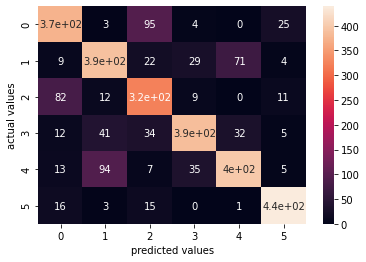

In [49]:
# Evaluating the model with confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

## Visualizing the confusion matrix
sns.heatmap(conf_matrix, annot = True,  fmt='.2g')
plt.xlabel ('predicted values')
plt.ylabel ('actual values')

plt.show()

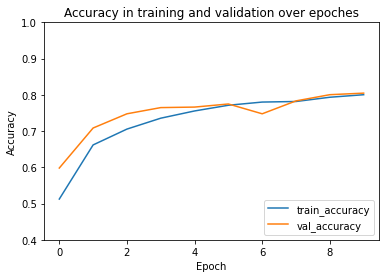

In [43]:
# Plotting the performance of the model over training
plt.plot(history.history['accuracy'], label = 'train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy in training and validation over epoches')
plt.ylim([0.4, 1])
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
# Applied the model to predict the unseen data
y_pred = cnn.predict(X_pred)